In [2]:
import numpy as np
import matplotlib.pyplot as plt
import graphlearning as gl
from scipy.optimize import minimize, LinearConstraint
import sklearn.datasets as datasets
import scipy

$$I[u] = \frac{1}{2p} \sum_{i,j=1}^n w_{i j} | \nabla u(x_i,x_j) |^p - \sum_{j=1}^m(y_j - \bar{y}) \cdot u(x_j)$$
where $$ \nabla u(x_i, x_j) = u(x_j) - u(x_i) $$

In [53]:
# Calculates vector of degrees for the weight matrix W
# W: (n,k) numpy array
    
def degrees(W):
    return W.sum(axis = 1)

# Example
# Calculates degrees of equilateral triangle
# W = np.array([[0, 1, 1], [1,0,1], [1,1,0]])
# print(degrees(W))

"""
Computes the gradient of u
u: (n,k) matrix
"""
def grad(u):
    gradu = -u[:, np.newaxis] + u

    return gradu
            
"""
u_flattened: n*k matrix
W: weight matrix
y: (m,k) matrix
idx = vector of labelled indices
p = p constant for laplace operator
"""
def penergy(u_flattened, W, idx, y, p):
    k = y.shape[1]
    n = int(u_flattened.size/k)
    u = u_flattened.reshape((n,k))
    gradu = grad(u)
    y_bar = (1/y.shape[0]) * y.sum(axis = 0)
    
    first_summand = (1/(2*p)) * (W * (np.apply_along_axis(np.linalg.norm, 2, gradu) ** p)).sum()
    second_summand = np.sum( (y - y_bar) * u[idx] )

    return first_summand - second_summand

# ## Example (see pdf)
# u = np.array([[1,0], [0,1], [1/2, 1/2]])
# print(grad(u))
# y = np.array([[1,0], [0,1]])
# W = np.array([[0, 1, 1], [1,0,1], [1,1,0]])
# idx = [0, 1]
# p = 2

# #print(np.apply_along_axis(np.linalg.norm, 2, grad(u)))
# print("2-energy is", penergy(u, W, idx, y, 2))
# print("3-energy is", penergy(u, W, idx, y, 3))

# Returns the ith vector of the usual basis of R^k
# Index starts at 0
def euclidean_basis(i, k):
    eye = np.eye(k)
    return eye[i]

# Example
# print(euclidean_basis(0, 4))
# print(euclidean_basis(2, 4))

# Returns the labels that u predicts
def predict(u):
    return np.argmax(u, axis = 1)

# Solves the p-poisson equation on a graph with weight matrix W
# and labels y on the elements with indices idx
# using gradient descent
def gradient_ppoisson(W, idx, y, p):
    d = degrees(W)
    n = W.shape[0]
    k = y.shape[1]
    eye = np.eye(k)

    constrain_matrix = np.concatenate([d[i] * eye for i in range(n)], axis = 1)
    linear_constraint = LinearConstraint(constrain_matrix, np.zeros(k), np.zeros(k))
    
    res = minimize(penergy, x0 = np.zeros(n * k), args = (W, idx, y, p), method = 'trust-constr', constraints = linear_constraint)
    u = res.x.reshape(n,k)
    
    return u

# Example
y = np.array([[1,0], [0,1]])
W = np.array([[0, 1, 1], [1,0,1], [1,1,0]])
idx = [0, 1]
p = 2

u = gradient_ppoisson(W, idx, y, p)
print("Minimizer:\n", u)
print("Energy of minimizer:", penergy(u, W, idx, y, p))
print("Negative Laplacian values:", 2*u[0]-u[1]-u[2], 2*u[1]-u[0]-u[2], 2*u[2]-u[0]-u[1], sep="\n")
print("Labels:", predict(u))

Minimizer:
 [[ 1.66666669e-01 -1.66666669e-01]
 [-1.66666669e-01  1.66666669e-01]
 [ 3.11035723e-18  3.11035723e-18]]
Energy of minimizer: -0.16666666666666663
Negative Laplacian values:
[ 0.50000001 -0.50000001]
[-0.50000001  0.50000001]
[0. 0.]
Labels: [0 1 0]


### Functions made for debugging

In [54]:
def slow_penergy(u_flattened, W, idx, y, p):
    k = y.shape[1]
    n = int(u_flattened.size/k)
    m = y.shape[0]
    u = u_flattened.reshape((n,k))
    gradu = grad(u)
    
    y_bar = (1/y.shape[0]) * y.sum(axis = 0)
    
    first_summand = 0
    for i in range(n):
        for j in range(n):
            first_summand += np.linalg.norm(gradu[i,j])**p
    first_summand /= 2 * p
    
    second_summand = 0
    for j in range(m):
        second_summand += np.inner( (y[j]-y_bar), u[j])
    
    return first_summand - second_summand

def started_gradient_ppoisson(W, idx, y, p, start):
    d = degrees(W)
    n = W.shape[0]
    k = y.shape[1]
    eye = np.eye(k)

    constrain_matrix = np.concatenate([d[i] * eye for i in range(n)], axis = 1)
    # print(constrain_matrix)
    linear_constraint = LinearConstraint(constrain_matrix, np.zeros(k), np.zeros(k))
    res = minimize(slow_penergy, x0 = start, args = (W, idx, y, p), method = 'trust-constr', constraints = linear_constraint)
    u = res.x.reshape(n,k)
    
    return u

In [55]:
# Toy example using graph learn
y = np.array([[1,0], [0,1]])
W = np.array([[0, 1, 1], [1,0,1], [1,1,0]])
d = degrees(W)
idx = [0, 1]
n = 3
k = 2
p = 2

model = gl.ssl.poisson(W)
u = model.fit(idx, np.array([0, 1]))
# print(2*u[0]-u[1]-u[2])
# print(2*u[1]-u[0]-u[2])
# print(2*u[2]-u[0]-u[1])
# print(u[0] + u[1] + u[2])
print("GraphLearn solution: \n", u)

# Toy example using custom implementation
my_u = gradient_ppoisson(W, idx, y, p)
print("Custom solution: \n", my_u)

GraphLearn solution: 
 [[ 0.16666667 -0.16666667]
 [-0.16666667  0.16666667]
 [ 0.          0.        ]]
Custom solution: 
 [[ 1.66666669e-01 -1.66666669e-01]
 [-1.66666669e-01  1.66666669e-01]
 [ 3.11035723e-18  3.11035723e-18]]


Energy of GraphLearning Solution: 8.687541466872855e+24
Energy of custom solution: 2.5005792464952184e+34
Accuracy of custom solution: 92.22222222222223
Accuracy of GraphLearn solution: 92.22222222222223
Number of different predictions 0


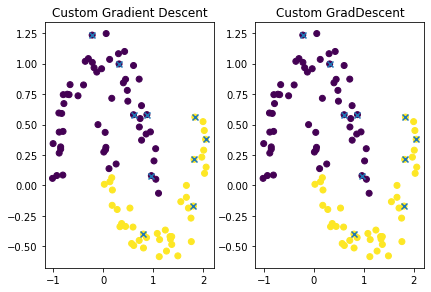

In [61]:
n = 100
k = 2

# Generate training data and label sets
X,labels = datasets.make_moons(n_samples=n,noise=0.1)
W = gl.weightmatrix.knn(X,10).toarray()

train_ind = gl.trainsets.generate(labels, rate=5)
train_labels = labels[train_ind]
m = train_ind.size

y = np.zeros((m, k))
for i in range(train_ind.size):
    y[i] = euclidean_basis(train_labels[i], k)
    
# Custom Gradient Descent
my_u = gradient_ppoisson(W, train_ind, y, p = 2)
my_pred_labels = predict(my_u)

fig, ax = plt.subplots(ncols = 2)
fig.tight_layout()

ax[0].scatter(X[:,0],X[:,1], c=my_pred_labels)
ax[0].scatter(X[train_ind,0],X[train_ind,1], marker='x')
ax[0].set_title("Custom Gradient Descent")

# Using graph learning toolkit
train_labels = labels[train_ind]

model = gl.ssl.poisson(W, solver='gradient_descent')
u = model.fit(train_ind, train_labels)
pred_labels = predict(u)
ax[1].scatter(X[:,0],X[:,1], c=pred_labels)
ax[1].scatter(X[train_ind,0],X[train_ind,1], marker='x')
ax[1].set_title("Custom GradDescent")

print("Energy of GraphLearning Solution:", penergy(u.flatten(), W, train_ind, y, p))
print("Energy of custom solution:", penergy(my_u.flatten(), W, train_ind, y, p))
print("Accuracy of custom solution:", gl.ssl.ssl_accuracy(my_pred_labels, labels, len(train_ind)))
print("Accuracy of GraphLearn solution:", gl.ssl.ssl_accuracy(pred_labels, labels, len(train_ind)))
print("Number of different predictions", np.count_nonzero(my_pred_labels - pred_labels))

plt.show()

KeyboardInterrupt: 

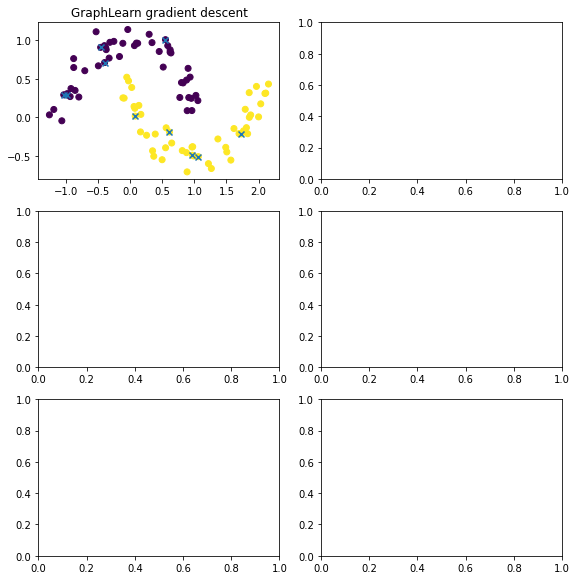

In [62]:
n = 100
k = 2
p_vals = [[0, 2], [4, 8], [16, 32]]

# Array holding infos for each p
info_str = p_vals

# Generate training data and label sets
X,labels = datasets.make_moons(n_samples=n,noise=0.1)
W = gl.weightmatrix.knn(X,10).toarray()

train_ind = gl.trainsets.generate(labels, rate=5)
train_labels = labels[train_ind]
m = train_ind.size

y = np.zeros((m, k))
for i in range(train_ind.size):
    y[i] = euclidean_basis(train_labels[i], k)

fig, ax = plt.subplots(nrows = len(p_vals), ncols = len(p_vals[0]), figsize = (8, 8))
fig.tight_layout()

# Run and plot for varying p
for i in range(len(p_vals)):
    for j in range(len(p_vals[i])):
        p = p_vals[i][j]

        if p == 0: # Apply GraphLearning
            model = gl.ssl.poisson(W, solver='gradient_descent')
            u = model.fit(train_ind, train_labels)
            pred_labels = predict(u)

            accuracy = gl.ssl.ssl_accuracy(pred_labels, labels, len(train_ind))
            energy = np.around(penergy(u.flatten(), W, train_ind, y, 2), 2)

            info_str[i][j] = f"########### GraphLearning\n"\
                            f"Energy = {energy:.2f}\n"\
                            f"Accuracy = {accuracy:.2f}%" 
            ax[i, j].scatter(X[:,0],X[:,1], c=pred_labels)
            ax[i, j].scatter(X[train_ind,0],X[train_ind,1], marker='x', label = "Labeled nodes")
            ax[i, j].set_title(f"GraphLearn gradient descent")

        else: # Apply custom learning
            my_u = gradient_ppoisson(W, train_ind, y, p)
            my_pred_labels = predict(my_u)

            discrepancies = np.count_nonzero(my_pred_labels - pred_labels)
            accuracy = gl.ssl.ssl_accuracy(my_pred_labels, labels, len(train_ind))
            energy = np.around(penergy(my_u.flatten(), W, train_ind, y, p), 2)
            info_str[i][j] = f"########### Custom Gradient Descent for p = {p}\n"\
                            f"Energy = {energy:.2f}\n"\
                            f"Discrepancies = {discrepancies}"\
                            f"\nAccuracy = {accuracy:.2f}%"

            ax[i, j].scatter(X[:,0],X[:,1], c=my_pred_labels)
            ax[i, j].scatter(X[train_ind,0],X[train_ind,1], marker='x', label = "Labeled nodes")
            ax[i, j].set_title(f"p = {p}")
            
for i in range(len(info_str)):
    for j in range(len(info_str[0])):
        print(info_str[i][j])

plt.legend()
plt.show()

In [11]:
np.random.seed(1)
a = np.random.randint(20, size=(4,5, 3))
b = np.zeros((4,5,3))
print(a)
for i0 in range(a.shape[0]):
    for i1 in range(a.shape[1]):
        for j0 in range(a.shape[2]):
            # print(i0, i1, j0)
            b[i0,i1,j0] = a.flatten()[i0 * a.shape[2]*a.shape[1] + i1 * a.shape[2] + j0]
            # print(a.flatten()[i0 * a.shape[2]*a.shape[1] + i1 * a.shape[2] + j0])
print(np.array_equiv(a,b))

[[[ 5 11 12]
  [ 8  9 11]
  [ 5 15  0]
  [16  1 12]
  [ 7 13  6]]

 [[18  5 18]
  [11 10 14]
  [18  4  9]
  [17  0 13]
  [ 9  9  7]]

 [[ 1  0 17]
  [ 8 13 19]
  [15 10  8]
  [ 7  3  6]
  [17  3  4]]

 [[17 11 12]
  [16 13 19]
  [ 9 18 15]
  [ 0  4 15]
  [ 2  7  8]]]
True


In [10]:
np.random.seed(1)
n0, n1, n2, n3 = [4, 5, 3, 2]

a = np.random.randint(20, size=(n0, n1, n2, n3))
b = np.zeros((n0, n1, n2, n3))

for i0 in range(a.shape[0]):
    for i1 in range(a.shape[1]):
        for j0 in range(a.shape[2]):
            for j1 in range(a.shape[3]):
                b[i0,i1,j0, j1] = a.flatten()[i0 * a.shape[3]*a.shape[2]*a.shape[1] + i1 * a.shape[3] *a.shape[2] + j0 * a.shape[3] + j1]
                
print(np.array_equiv(a,b))

True


In [24]:
W = scipy.sparse.csr_matrix([ [0, 5, 1, 8], [5, 0, 2, 0], [1, 2, 0, 0], [8, 0, 0, 0] ])
u = np.array([ [4, 3, 1], [2, 8, 7], [1, 2, 3], [0, 5, 1] ])
print(W.toarray())
I, J, V = scipy.sparse.find(W)
print(I)
print(J)
# print(u[I])
# print(u[J])
#Grad = scipy.sparse.coo_matrix((u[J]-u[I], (I,J)),shape=(4,4,3)).tocsr()
gradu = u[:, np.newaxis] - u
print(gradu)

[[0 5 1 8]
 [5 0 2 0]
 [1 2 0 0]
 [8 0 0 0]]
[1 2 3 0 2 0 1 0]
[0 0 0 1 1 2 2 3]
[[[ 0  0  0]
  [ 2 -5 -6]
  [ 3  1 -2]
  [ 4 -2  0]]

 [[-2  5  6]
  [ 0  0  0]
  [ 1  6  4]
  [ 2  3  6]]

 [[-3 -1  2]
  [-1 -6 -4]
  [ 0  0  0]
  [ 1 -3  2]]

 [[-4  2  0]
  [-2 -3 -6]
  [-1  3 -2]
  [ 0  0  0]]]


In [22]:
a = np.random.randint(20, size=(4,5))
print(a)
a[:, np.newaxis] - a

[[18  0  0  5  1]
 [18 15  8 19  2]
 [ 8 17 18 12  1]
 [ 9 14 19 10  3]]


array([[[  0,   0,   0,   0,   0],
        [  0, -15,  -8, -14,  -1],
        [ 10, -17, -18,  -7,   0],
        [  9, -14, -19,  -5,  -2]],

       [[  0,  15,   8,  14,   1],
        [  0,   0,   0,   0,   0],
        [ 10,  -2, -10,   7,   1],
        [  9,   1, -11,   9,  -1]],

       [[-10,  17,  18,   7,   0],
        [-10,   2,  10,  -7,  -1],
        [  0,   0,   0,   0,   0],
        [ -1,   3,  -1,   2,  -2]],

       [[ -9,  14,  19,   5,   2],
        [ -9,  -1,  11,  -9,   1],
        [  1,  -3,   1,  -2,   2],
        [  0,   0,   0,   0,   0]]])

In [50]:
## Example (see pdf)
u = np.array([[1,0], [0,1], [1/2, 1/2]])
#print(grad(u))
y = np.array([[1,0], [0,1]])
W = np.array([[0, 1, 1], [1,0,1], [1,1,0]])
idx = [0, 1]
p = 2
print(grad(u)[2,1])

[-0.5  0.5]
